In [22]:
PKL_FILE = 'data/repos-Java-2023-03-30-2271.pkl'
PKL_FILE = 'data/repos-cleaned-Java-2023-03-30-2271.pkl'

DEEPJIT_DATA_FOLDER = 'data/deepjit_summary_data'

In [1]:
import os, sys, json, pickle, re, random, pprint, importlib
from tqdm import tqdm

# cd to repo root
os.chdir(os.path.dirname(os.getcwd()))

sys.path.append('lib')

from parsers import comments_fuzzy_equal

In [24]:
print('Loading deepjit data...')
dj_train = json.load(open(os.path.join(DEEPJIT_DATA_FOLDER, 'train.json')))
dj_valid = json.load(open(os.path.join(DEEPJIT_DATA_FOLDER, 'valid.json')))
dj_test = json.load(open(os.path.join(DEEPJIT_DATA_FOLDER, 'test.json')))
print(f'Loaded {len(dj_train)} train examples, {len(dj_valid)} valid examples, {len(dj_test)} test examples from deepjit dataset')

print('Loading our data...')
pkl_examples, metadata = pickle.load(open(PKL_FILE, 'rb'))

# Delete all examples where old code and new code are fuzzy equal
# TODO: remove this with new mined data
for repo_name, examples in tqdm(pkl_examples.items(), total=len(pkl_examples)):
    pkl_examples[repo_name] = [example for example in examples if not comments_fuzzy_equal(example['old_code_raw'], example['new_code_raw'])]

print(f'Loaded {len(pkl_examples)} repos from our dataset')
# pkl_examples is dict of keys repo_name -> list of examples
print(f'Total number of examples: {sum([len(examples) for examples in pkl_examples.values()])}')

Loading deepjit data...
Loaded 8398 train examples, 1034 valid examples, 1066 test examples from deepjit dataset
Loading our data...


100%|██████████| 910/910 [00:42<00:00, 21.19it/s]

Loaded 910 repos from our dataset
Total number of examples: 357649


100%|██████████| 1066/1066 [00:22<00:00, 47.74it/s]


Median: 63.0, Max: 977, Min: 1, Mean: 151.91141732283464


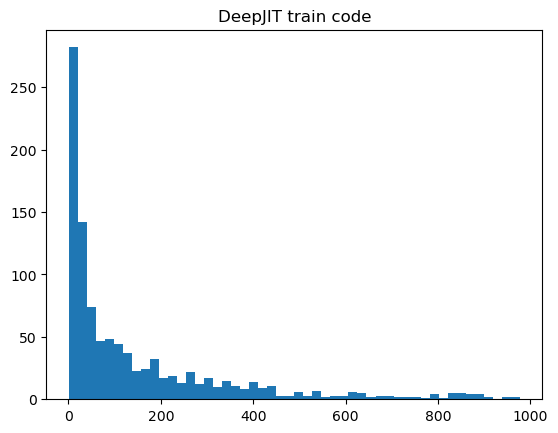

100%|██████████| 1066/1066 [00:00<00:00, 5588.25it/s]


Median: 18.0, Max: 98, Min: 1, Mean: 27.20703125


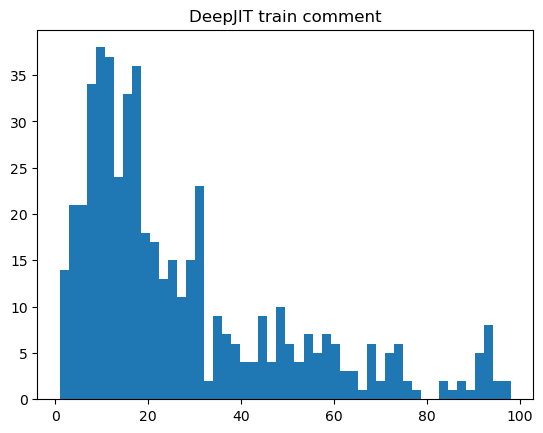

In [25]:
import difflib
def non_space_diff_count(a, b):
    '''Return the number of non-space characters that differ between a and b'''
    diff = difflib.ndiff(a, b)
    return sum(1 for c in diff if c[0] != ' ' and c[-1] != ' ')

import matplotlib.pyplot as plt
import numpy as np

# Plot the non space diff count distribution for the deepjit dataset between old and new code
def plot_diff_count_distribution(examples, title, type='code', cutoff=-1):
    diff_counts = []
    for example in tqdm(examples):
        if type == 'code':
            old, new = example['old_code_raw'], example['new_code_raw']
        if type == 'comment':
            old, new = example['old_comment_raw'], example['new_comment_raw']
            if example['label'] == 0:
                continue
        diff_counts.append(non_space_diff_count(old, new))
    diff_counts = [x for x in diff_counts if x < cutoff or cutoff == -1]
    plt.hist(diff_counts, bins=50)
    plt.title(title)
    # Print median, max, min, mean
    print(f'Median: {np.median(diff_counts)}, Max: {np.max(diff_counts)}, Min: {np.min(diff_counts)}, Mean: {np.mean(diff_counts)}')
    plt.show()

plot_diff_count_distribution(dj_test, 'DeepJIT train code', type='code', cutoff=1000)
plot_diff_count_distribution(dj_test, 'DeepJIT train comment', type='comment', cutoff=100)

In [26]:
# Print examples where the diff is just 1
random.shuffle(dj_train)
for example in dj_train:
    if non_space_diff_count(example['old_code_raw'], example['new_code_raw']) == 1:
        print(f'Old code:\n{example["old_code_raw"]}')
        print(f'New code:\n{example["new_code_raw"]}')
        break

for example in dj_train:
    # Do any of their comments start with a non capital letter?
    if 'todo' in example['old_comment_raw'].lower():
        print(f'Old comment:\n{example["old_comment_raw"]}')
        print(f'New comment:\n{example["new_comment_raw"]}')
        break
    if non_space_diff_count(example['old_comment_raw'], example['new_comment_raw']) == 1:
        print(f'Old comment:\n{example["old_comment_raw"]}')
        print(f'New comment:\n{example["new_comment_raw"]}')
        break

Old code:
    private static boolean isFirstInLine(String line, int columnNo) {
        return CommonUtils.isBlank(line.substring(0, columnNo));
    }

New code:
    private static boolean isFirstInLine(String line, int columnNo) {
        return CommonUtil.isBlank(line.substring(0, columnNo));
    }

Old comment:
Get start select items.
New comment:
Get star select items.


100%|██████████| 60000/60000 [16:10<00:00, 61.80it/s]  


Median: 47.0, Max: 999, Min: 1, Mean: 131.88559403433402


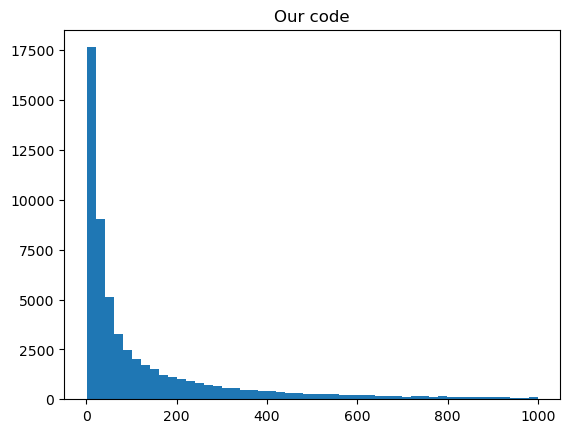

100%|██████████| 60000/60000 [00:01<00:00, 40988.73it/s]


Median: 24.0, Max: 99, Min: 6, Mean: 31.475467702082597


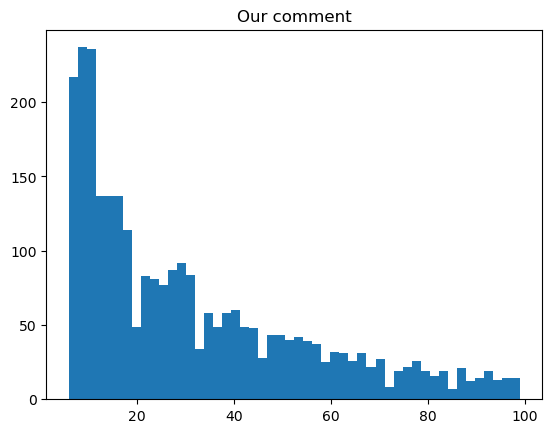

In [27]:
# Plot the same histograms for all our examples
all_our_examples = []
for examples in pkl_examples.values():
    all_our_examples.extend(examples)
# Sample down to 60k
random.shuffle(all_our_examples)
all_our_examples = all_our_examples[:60000]
plot_diff_count_distribution(all_our_examples, 'Our code', type='code', cutoff=1000)
plot_diff_count_distribution(all_our_examples, 'Our comment', type='comment', cutoff=100)

In [28]:
pkl_repo_names_normalised = {repo_name.lower().replace('/', '').replace('-', '').replace('_', ''): repo_name for repo_name in pkl_examples.keys()}

def normalised_repo_from_deepjit_example(ex):
    """Get normalised repo name from deepjit example"""
    return '-'.join(ex['id'].split('-')[:-3]).lower().replace('/', '').replace('-', '').replace('_', '')

all_dj_repos = set([normalised_repo_from_deepjit_example(ex) for ex in dj_train + dj_valid + dj_test])

# Are we missing any repositories?
seen = []
for example in dj_train + dj_valid + dj_test:
    normalised_repo = normalised_repo_from_deepjit_example(example)
    if normalised_repo not in pkl_repo_names_normalised:
        seen.append(normalised_repo)
n_seen = len(seen)
seen = set(seen)
print(f'Total number of repos not found: {len(seen)} of {len(all_dj_repos)}')
print(f'Total number of examples not found: {n_seen} of {len(dj_train) + len(dj_valid) + len(dj_test)}')

Total number of repos not found: 77 of 977
Total number of examples not found: 362 of 10498


In [29]:
# Group our examples by the method name within each repo to make searching much faster

from parsers import get_language_and_parser

language, parser = get_language_and_parser('java')
method_name_query = language.query('((method_declaration name: (_) @name))')

def get_method_name(method_body):
    code = f'class A {{ {method_body} }}'
    tree = parser.parse(bytes(code, 'utf-8'))
    node = tree.root_node
    methods = method_name_query.captures(node)
    try:
        return methods[0][0].text.decode()
    except:
        return '(unknown method name)'


our_repo_names = list(pkl_examples.keys())
pkl_examples_by_method = {}
for name in tqdm(our_repo_names):
    by_method = {}
    for ex in pkl_examples[name]:
        method_name = get_method_name(ex['new_code_raw'])
        if method_name not in by_method:
            by_method[method_name] = []
        by_method[method_name].append(ex)
    pkl_examples_by_method[name] = by_method


100%|██████████| 910/910 [01:11<00:00, 12.69it/s]


In [30]:
# Given a Deepjit example, do we have a corresponding example in our dataset?

from diffs import non_space_diff_ratio, closest_in_list

def find_example_in_our_dataset(dj_ex, same_label=False):
    """Find example in our dataset"""
    normalised_repo = normalised_repo_from_deepjit_example(dj_ex)
    if normalised_repo not in pkl_repo_names_normalised:
        return None, -1
    method_name = get_method_name(dj_ex['new_code_raw'])
    repo_name = pkl_repo_names_normalised[normalised_repo]
    repo_examples = pkl_examples_by_method[repo_name]
    if not repo_examples:
        return None, -1
    if method_name in repo_examples:
        iterator = repo_examples[method_name]
    else:
        cloest_method_name, _ = closest_in_list(method_name, repo_examples.keys())
        iterator = repo_examples[cloest_method_name]
    if same_label:
        iterator = [ex for ex in iterator if ex['label'] == dj_ex['label']]
    data_string = dj_ex['old_comment_raw'] + dj_ex['new_code_raw']
    return closest_in_list(data_string, iterator, key=lambda x: x['old_comment_raw'] + x['new_code_raw'])

# Test it on a random example from the deepjit training set
dj_ex = random.choice(dj_train)
our_ex, ratio = find_example_in_our_dataset(dj_ex)
print('Deepjit example:')
print(dj_ex['old_comment_raw'])
print(dj_ex['new_code_raw'])
if our_ex:
    print('Our example:')
    print(our_ex['repo_url'])
    print(our_ex['old_comment_raw'])
    print(our_ex['new_code_raw'])
    print(f'Match ratio: {ratio}')
else:
    print(f'Repo not in our dataset? {normalised_repo_from_deepjit_example(dj_ex)}')

Deepjit example:
Creates a new AndroidResourcesProvider with the supplied ResourceContainer as the direct dep.
  public AndroidResourcesProvider toProvider(Label label, ResourceContainer newDirectResource) {
    if (neverlink) {
      return ResourceDependencies.empty().toProvider(label);
    }
    return AndroidResourcesProvider.create(
        label,
        NestedSetBuilder.<ResourceContainer>naiveLinkOrder()
            .addTransitive(transitiveResources)
            .addTransitive(directResources)
            .build(),
        NestedSetBuilder.<ResourceContainer>naiveLinkOrder().add(newDirectResource).build());
  }

Our example:
https://github.com/bazelbuild/bazel.git
Creates a new AndroidResourcesProvider with the supplied ResourceContainer as the direct dep.
public AndroidResourcesProvider toProvider(Label label, ResourceContainer newDirectResource) {
  if (neverlink) {
    return ResourceDependencies.empty().toProvider(label);
  }
  return AndroidResourcesProvider.create(
     

In [31]:
# Create matched sets where we use our examples, only if the match score is >0.7

def make_match_list(dj_examples, same_label=False):
    matches = []
    bar = tqdm(dj_examples, bar_format='{l_bar}{bar:16}{r_bar}')
    for dj_ex in bar:
        our_ex, ratio = find_example_in_our_dataset(dj_ex, same_label=same_label)
        matches.append((dj_ex, our_ex, ratio))
        ratio_avg = sum([m[2] for m in matches]) / len(matches)
        bar.set_postfix_str(f'[Ratio: {ratio_avg : .3f}]')
    return matches

dj_train_matched = make_match_list(dj_train, True)
dj_valid_matched = make_match_list(dj_valid, True)
dj_test_matched = make_match_list(dj_test, True)

100%|████████████████| 1066/1066 [00:05<00:00, 184.49it/s, [Ratio:  0.362]]


In [32]:
# Number of non-None matches, out of the total?

def get_match_stats(matches):
    n_matches = len([m for m in matches if m[1] is not None])
    n_total = len(matches)
    return f'Matched {n_matches} of {n_total} ({n_matches / n_total * 100: .2f}%)'

# Print out stats
print(f'Train: {get_match_stats(dj_train_matched)}')
print(f'Valid: {get_match_stats(dj_valid_matched)}')
print(f'Test: {get_match_stats(dj_test_matched)}')

Train: Matched 6064 of 8398 ( 72.21%)
Valid: Matched 760 of 1034 ( 73.50%)
Test: Matched 806 of 1066 ( 75.61%)


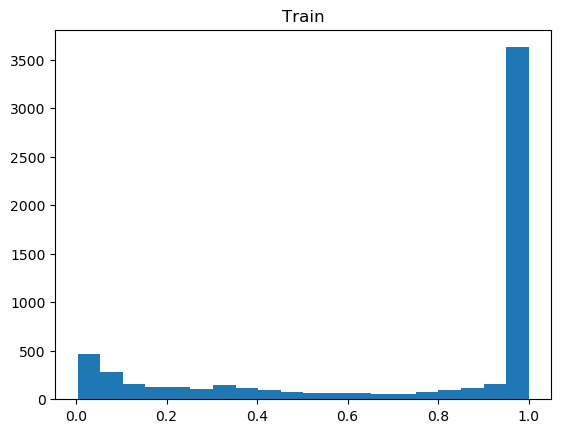

Median: 1.0
Mean: 0.7407542349710413


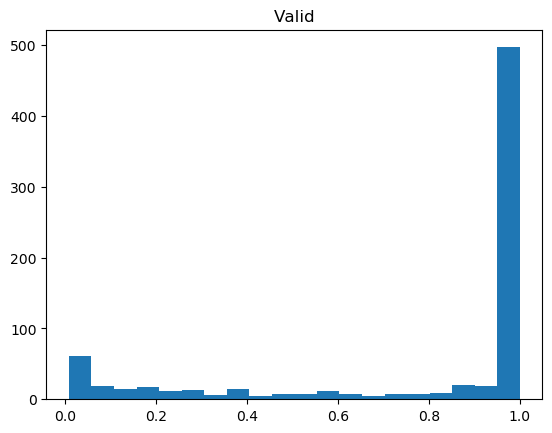

Median: 1.0
Mean: 0.7852870334097196


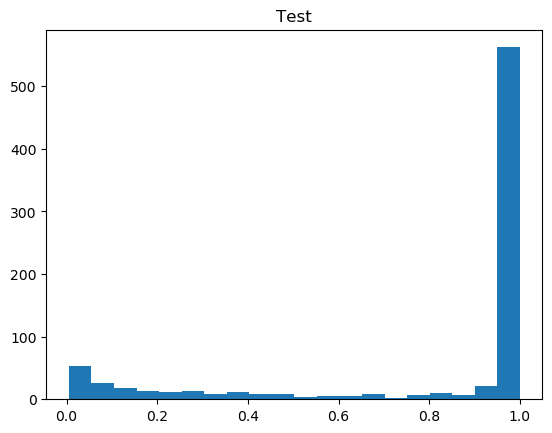

Median: 1.0
Mean: 0.8008700708579154


In [33]:
# Plot histogram for each list of match scores, and print median/max

import matplotlib.pyplot as plt
import numpy as np

def plot_match_scores(matches, title):
    """Plot histogram of match scores"""
    scores = [m[2] for m in matches if m[1] != None]
    plt.hist(scores, bins=20)
    plt.title(title)
    plt.show()
    print(f'Median: {np.median(scores)}')
    print(f'Mean: {np.mean(scores)}')

plot_match_scores(dj_train_matched, 'Train')
plot_match_scores(dj_valid_matched, 'Valid')
plot_match_scores(dj_test_matched, 'Test')

In [34]:
# Look at some of the 0.7-0.9 matches to see why it's close but not quite the same

def join_ex(ex):
    out = '// ' + ex['old_comment_raw'] + '\n' + ex['new_code_raw']
    if ex['label'] == 1:
        out += '\n' + 'New comment: ' + ex['new_comment_raw']
    return out

close_matches_train = [m for m in dj_train_matched if 0.5 < m[2] < 0.8]
close_matches_train = sorted(close_matches_train, key=lambda x: x[2])
# Print out 3 of them
for i in range(len(close_matches_train)):
    m = random.choice(close_matches_train)
    print('Deepjit example:')
    print(join_ex(m[0]))
    print('Our example:')
    print(join_ex(m[1]))
    # Print labels and whether they match
    print(f'Labels: Deepjit: {m[0]["label"]}, Ours: {m[1]["label"]}, Same? {m[0]["label"] == m[1]["label"]}')
    print(f'Match ratio: {m[2]}')
    # Repo, path, commit
    print(f'Repo: {m[1]["repo_url"]}, Path: {m[1]["path"]}, Commit: {m[1]["commit"]}')

close_matches_train = sorted(close_matches_train, key=lambda x: x[2])

Deepjit example:
// Filters the data in the container and updates internal data structures.
    protected boolean doFilterContainer(boolean hasFilters) {
        if (!hasFilters) {
            filteredItemIds = null;
            if (filters != null) {
                filters = null;
                return true;
            }

            return false;
        }
        // Reset filtered list
        if (filteredItemIds == null) {
            filteredItemIds = new LinkedHashSet<Object>();
        } else {
            filteredItemIds.clear();
        }

        // Filter
        for (final Iterator<?> i = itemIds.iterator(); i.hasNext();) {
            final Object id = i.next();
            if (passesFilters(id)) {
                filteredItemIds.add(id);
            }
        }

        return true;

    }

Our example:
// Filters the data in the container and updates internal data structures.
protected boolean doFilterContainer(boolean hasFilters) {
    if (!hasFilters) {
        setF

In [52]:
from collections import Counter
from itertools import chain

non_matches = [m for m in dj_train_matched + dj_valid_matched + dj_test_matched if m[1] is None]
nonmatch_counter = Counter([normalised_repo_from_deepjit_example(m[0]) for m in non_matches])

matches = [m for m in dj_train_matched + dj_valid_matched + dj_test_matched if m[1] is not None]
match_counter = Counter([normalised_repo_from_deepjit_example(m[0]) for m in matches])

def get_match_ratio(repo):
    if repo not in match_counter:
        return 0
    return match_counter[repo] / (match_counter[repo] + nonmatch_counter[repo])

# Map dict of match ratio of each repo
match_ratios = {repo: get_match_ratio(repo) for repo in chain(match_counter.keys(), nonmatch_counter.keys())}
# Print the 10 lowest and the 10 highest ratios
print('Lowest nonzero match ratios:')
printed = 0
for repo, ratio in sorted(match_ratios.items(), key=lambda x: x[1]):
    if ratio > 0:
        print(f'{repo}: {ratio}')
        printed += 1
        if printed == 10:
            break

print('Highest match ratios:')
for repo, ratio in sorted(match_ratios.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f'{repo}: {ratio}')


Lowest nonzero match ratios:
andyglickjaudiotagger: 0.045454545454545456
mulesoftmule: 0.07692307692307693
apachecxf: 0.09090909090909091
apachelenya: 0.10256410256410256
deeplearning4jdeeplearning4j: 0.13333333333333333
apacheant: 0.14285714285714285
androidplatformframeworksbase: 0.16129032258064516
apachedirectoryfortresscore: 0.18181818181818182
eclipsebirt: 0.1956521739130435
apachepoi: 0.2
Highest match ratios:
actorappactorplatform: 1.0
timehopstickyheadersrecyclerview: 1.0
lightbendconfig: 1.0
koralandroidgifdrawable: 1.0
apachecordovaandroid: 1.0
sonatypeplexuscompiler: 1.0
commonsappappsandroidcommons: 1.0
nickmanjmxtools: 1.0
alibabaarouter: 1.0
sonarsourcesonarqube: 1.0


In [51]:
# Print all the deep jit non-matches in the training set
print(f'Printing {len(non_matches)} non-matches')
for m in non_matches:
    print(join_ex(m[0]))
    print(f'Example repo: {normalised_repo_from_deepjit_example(m[0])}, label: {m[0]["label"]}')

Printing 2868 non-matches
// Returns a list of file to persist, removing them from the internal queue.
  public List<Long> popPersistedFiles() {
    List<Long> toReturn = Lists.newArrayList();
    synchronized (mPersistedFiles) {
      toReturn.addAll(mPersistedFiles);
      mPersistedFiles.clear();
      return toReturn;
    }
  }


New comment: Populates the persisted files.
Example repo: alluxioalluxio, label: 1
// Strip leading spaces from every line in a String.
    public static String stripIndent(CharSequence self) {
        String s = self.toString();
        if (s.length() == 0) return s;
        int runningCount = -1;
        try {
            for (String line : readLines((CharSequence) s)) {
                // don't take blank lines into account for calculating the indent
                if (isAllWhitespace((CharSequence) line)) continue;
                if (runningCount == -1) runningCount = line.length();
                runningCount = findMinimumLeadingSpaces(line, runnin

In [65]:
def make_full_matched_list_balanced(dj_matched_list):
    used_ours = set()
    seen_repos = set()
    result = []
    for dj_ex, our_ex, ratio in dj_matched_list:
        if our_ex is not None:
            our_ex_id = our_ex['old_comment_raw'] + our_ex['new_code_raw']
            if our_ex_id not in used_ours:
                result.append(our_ex)
                used_ours.add(our_ex_id)
                seen_repos.add(pkl_repo_names_normalised[normalised_repo_from_deepjit_example(dj_ex)])
    fillers = []
    # Add the rest of our examples from those repos
    for repo in pkl_examples:
        if repo in seen_repos:
            for ex in pkl_examples[repo]:
                our_ex_id = ex['old_comment_raw'] + ex['new_code_raw']
                if our_ex_id not in used_ours:
                    fillers.append(ex)
                    used_ours.add(our_ex_id)

    # Return all the matched result, plus some fillers until we reach the same size as the deepjit list
    result_pos = [ex for ex in result if ex['label'] == 1]
    result_neg = [ex for ex in result if ex['label'] == 0]
    shortest_list = min(len(result_pos), len(result_neg))
    return result_pos[:shortest_list] + result_neg[:shortest_list]

    # Should we pad out the number of results with fillers?
    # Make sure the final list is balanced
    target_class_size = len(dj_matched_list) // 2
    random.shuffle(fillers)
    print(f'Used {len(result_pos) + len(result_neg)} examples from {len(seen_repos)} repos')
    fillers_pos = [ex for ex in fillers if ex['label'] == 1]
    fillers_neg = [ex for ex in fillers if ex['label'] == 0]
    if len(result_neg) < target_class_size:
        result_neg += fillers_neg[:target_class_size - len(result_neg)]
    if len(result_pos) < target_class_size:
        result_pos += fillers_pos[:target_class_size - len(result_pos)]
    return result_pos + result_neg

final_train = make_full_matched_list_balanced(dj_train_matched)
print(f'Final train size: {len(final_train)}, positives: {sum([ex["label"] for ex in final_train])}')

final_valid = make_full_matched_list_balanced(dj_valid_matched)
print(f'Final valid size: {len(final_valid)}, positives: {sum([ex["label"] for ex in final_valid])}')

final_test = make_full_matched_list_balanced(dj_test_matched)
print(f'Final test size: {len(final_test)}, positives: {sum([ex["label"] for ex in final_test])}')

Final train size: 3200, positives: 1600
Final valid size: 464, positives: 232
Final test size: 542, positives: 271


In [66]:
# Write out the final train, valid and test sets to json arrays

import json

FOLDER_NAME = 'data/final_repro_data2'
# Make sure folder exists
os.makedirs(FOLDER_NAME, exist_ok=True)

with open(f'{FOLDER_NAME}/train.json', 'w') as f:
    json.dump(final_train, f)
with open(f'{FOLDER_NAME}/valid.json', 'w') as f:
    json.dump(final_valid, f)
with open(f'{FOLDER_NAME}/test.json', 'w') as f:
    json.dump(final_test, f)

print(f'Written to {FOLDER_NAME}')

Written to data/final_repro_data2
